In [20]:
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import re

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, LSTM, GRU
from keras.layers.wrappers import TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2, activity_l2
from keras.regularizers import l1, activity_l1
from keras.utils.visualize_util import plot

import pydot
import graphviz
from collections import Counter

import sklearn
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import precision_score, recall_score,f1_score, accuracy_score
from sklearn.utils import shuffle
from sklearn.cross_validation import StratifiedKFold, train_test_split, cross_val_score

from imblearn.over_sampling import SMOTE


print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib
Required Libraries loaded.


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
# Import the data and explore the first few rows
# Import the data and explore the first few rows

inhibitor  = pd.read_csv("C:/EPC_Data/TREC_BROKEN/No_Mh_Tag/aceinhibitor_no_mh.csv", sep=",")#, index_col='PMID')
header = inhibitor.columns.values
inhibitor.head()

,PMID,Label,TIABSMh
0,10099033,0,Effects of delapril in combination with indapa...
1,10099034,0,Clinical and neurohormonal effects of nicardip...
2,10099064,0,Effect of benazepril on endothelial function i...
3,10099075,0,Lowdose combination treatment for hypertension...
4,10130617,0,Development implementation and results of a su...


In [3]:
data = shuffle(inhibitor, random_state = 57)
data.head()

,PMID,Label,TIABSMh
873,7589767,0,Antihypertensive efficacy and safe use of once...
411,11281234,0,Comparison of two calcium blockers on hemodyna...
2145,9243145,0,More favourable haemodynamic effects from meto...
2061,9088591,0,The effect of the neutral endopeptidase inhibi...
118,10740141,0,Randomized trial of candesartan cilexetil in t...


In [9]:
dataset = data.TIABSMh

In [4]:
#separate to negative and positive samples
# Select all rows with the index label "E"
negative_samples = inhibitor[inhibitor.Label == 0]#[lambda df: df.Label=='E', :]
positive_samples = inhibitor[inhibitor.Label == 1]#inhibitor.loc[lambda df: df.Label == 'I', :]

print ("Before resampling:")
print ("Whole dataset: ", inhibitor.shape)
print ("Positive sample: ", positive_samples.shape)
print ("Negative samples: ", negative_samples.shape)

#divide to training and test sets
train_neg = negative_samples.sample(frac=0.7, random_state=2)
test_neg = negative_samples.drop(train_neg.index)

train_pos = positive_samples.sample(frac=0.7, random_state=2)
test_pos = positive_samples.drop(train_pos.index)

input_label = ([1] * train_pos.shape[0] + [0] * train_neg.shape[0] + [1] * test_pos.shape[0] + [0] * test_neg.shape[0])


print (train_neg.shape)
print (test_neg.shape)
print (train_pos.shape)
print (test_pos.shape)

Before resampling:
('Whole dataset: ', (2498, 2))
('Positive sample: ', (39, 2))
('Negative samples: ', (2459, 2))
(1721, 2)
(738, 2)
(27, 2)
(12, 2)


In [6]:
#merge the samples
#pmid = [train_pos["PMID"],train_neg["PMID"],test_pos["PMID"],test_neg["PMID"]]
#id = pd.concat(pmid)
frames = [train_pos["TIABSMh"],train_neg["TIABSMh"],test_pos["TIABSMh"],test_neg["TIABSMh"]]
dataset = pd.concat(frames)

In [11]:
# Import articles for string cleaning
sample_len = dataset.size
def clean_text(text, stem_words = False, remove_stopwords = True):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
              
    clean_corpus = texts.lower().split()
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]#
    
    return (" ".join(clean_corpus))

In [12]:
print ("Cleaning and parsing the document...\n")

cleaned_corpus = []

count = 0
for i in dataset.index:
    if ((count+1)%200 == 0):
        print ("Processing %d of %d \n" %(count+1, sample_len))
        
    cleaned_corpus.append(clean_text(dataset.ix[i], stem_words = False, remove_stopwords = True))
    count +=1
print ("Finished data loading and cleaning")

Cleaning and parsing the document...

Processing 200 of 2498 

Processing 400 of 2498 

Processing 600 of 2498 

Processing 800 of 2498 

Processing 1000 of 2498 

Processing 1200 of 2498 

Processing 1400 of 2498 

Processing 1600 of 2498 

Processing 1800 of 2498 

Processing 2000 of 2498 

Processing 2200 of 2498 

Processing 2400 of 2498 

Finished data loading and cleaning


7494

In [13]:
#decide on the total number of terms to retain
num_words = 10000
tok = Tokenizer(num_words)
size = data.shape[0] 
print ("fitting ...")
tok.fit_on_texts(cleaned_corpus[:size])  #0 to 25000

print ("fitted to training data")

fitting ...
fitted to training data


In [14]:
words = []
for iter in range(num_words):
    words += [key for key,value in tok.word_index.items() if value==iter+1]

print "done"

done


In [15]:
words[:10]

['patients',
 'use',
 'effects',
 'blood',
 'treatment',
 'p',
 'aged',
 'pressure',
 'study',
 'enzyme']

In [16]:
#use the tokenizer to construct data matricies that look like the ones pre-supplied by keras
X = tok.texts_to_sequences(cleaned_corpus[:size])
#X_test  = tok.texts_to_sequences(cleaned_corpus[train_size:])
#y = input_label[:train_size]
#y_test  = input_label[train_size:]

y = data.Label

X = sequence.pad_sequences(X, maxlen=100)
#X_test  = sequence.pad_sequences(X_test,  maxlen=100)

print "done"

done


In [19]:
corpus = [X,X_test,y,y_test]
pickle.dump(corpus, open("inhibitor", "wb"))

In [47]:
corpus = pickle.load(open("inhibitor", "r"))
X,X_test,y,y_test = corpus

In [21]:
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

In [17]:
X.shape

(2498L, 100L)

In [21]:
#perform smote
sm = SMOTE(ratio = 'auto', kind = 'regular', random_state=50)

X_data, y_label = sm.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_label)))

X_train, X_test, y_train, y_test = train_test_split(X_data, y_label, random_state = 2)

Resampled dataset shape Counter({0: 2459, 1: 2459})


In [23]:
X_test.shape

(1230L, 100L)

In [ ]:
def func(x):
    x = np.where(x==0, 1, 5)
    return x 

sw=func(y_train)
wt=func(y_test)

#### build models

In [24]:
#1. Basic RNN
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(SimpleRNN(16, return_sequences=False))

model.add(Dense(128, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 100, 32)       320000      embedding_input_1[0][0]          
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 100, 32)       0           embedding_1[0][0]                
____________________________________________________________________________________________________
simplernn_1 (SimpleRNN)          (None, 16)            784         dropout_1[0][0]                  
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 128)           2176        simplernn_1[0][0]                
___________________________________________________________________________________________

In [25]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=3, verbose=1,
          validation_data=(X_test, y_test))#, sample_weight = sw,class_weight = {0:1., 1:25.})
score = model.evaluate(X_test, y_test, batch_size=32, verbose=0, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=32)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

Train on 3688 samples, validate on 1230 samples
Epoch 1/3
3688/3688 [==============================] - 1s - loss: 0.6996 - acc: 0.7381 - val_loss: 0.1693 - val_acc: 0.9610
Epoch 2/3
3688/3688 [==============================] - 1s - loss: 0.1899 - acc: 0.9807 - val_loss: 0.0782 - val_acc: 0.9797
Epoch 3/3
3688/3688 [==============================] - 1s - loss: 0.0911 - acc: 0.9900 - val_loss: 0.0569 - val_acc: 0.9854
('Test score:', 0.056913251048181117)
('Test accuracy:', 0.98536585365853657)


C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:437: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


*** AUC for ROC = 0.998

1216/1230 [============================>.] - ETA: 0s
Accuracy: 0.985365853659
Recall: 0.979966611018
Precision: 0.989881956155
F1: 0.984899328859


In [26]:
categories = ['Irrelevant', 'Relevant']
print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.99      0.99       631
   Relevant       0.99      0.98      0.98       599

avg / total       0.99      0.99      0.99      1230

confusion matrix:
[[625   6]
 [ 12 587]]


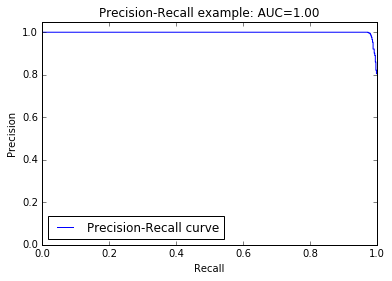

In [27]:
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [28]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(SimpleRNN(16, return_sequences=False))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('tanh'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
print model.summary()


plot(model, to_file='model.png')
model.get_config()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_2 (Embedding)          (None, 100, 32)       320000      embedding_input_2[0][0]          
____________________________________________________________________________________________________
dropout_3 (Dropout)              (None, 100, 32)       0           embedding_2[0][0]                
____________________________________________________________________________________________________
simplernn_2 (SimpleRNN)          (None, 16)            784         dropout_3[0][0]                  
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 256)           4352        simplernn_2[0][0]                
___________________________________________________________________________________________

[{'class_name': 'Embedding',
  'config': {'W_constraint': None,
   'W_regularizer': None,
   'activity_regularizer': None,
   'batch_input_shape': (None, 100),
   'dropout': 0.0,
   'init': 'uniform',
   'input_dim': 10000,
   'input_dtype': 'int32',
   'input_length': 100,
   'mask_zero': False,
   'name': 'embedding_2',
   'output_dim': 32,
   'trainable': True}},
 {'class_name': 'Dropout',
  'config': {'name': 'dropout_3', 'p': 0.25, 'trainable': True}},
 {'class_name': 'SimpleRNN',
  'config': {'U_regularizer': None,
   'W_regularizer': None,
   'activation': 'tanh',
   'b_regularizer': None,
   'consume_less': 'cpu',
   'dropout_U': 0.0,
   'dropout_W': 0.0,
   'go_backwards': False,
   'init': 'glorot_uniform',
   'inner_init': 'orthogonal',
   'input_dim': 32,
   'input_length': None,
   'name': 'simplernn_2',
   'output_dim': 16,
   'return_sequences': False,
   'stateful': False,
   'trainable': True,
   'unroll': False}},
 {'class_name': 'Dense',
  'config': {'W_constraint': 

In [29]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=5, verbose=0,
          validation_data=(X_test, y_test))#, sample_weight = sw, class_weight = {0:1., 1:25.})
score = model.evaluate(X_test, y_test, batch_size=32, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=32)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

1184/1230 [===========================>..] - ETA: 0s('Test score:', 0.096116192760021701)
('Test accuracy:', 0.96341463385558712)
*** AUC for ROC = 0.994

1184/1230 [===========================>..] - ETA: 0s
Accuracy: 0.963414634146
Recall: 0.946577629382
Precision: 0.977586206897
F1: 0.961832061069
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.95      0.98      0.96       631
   Relevant       0.98      0.95      0.96       599

avg / total       0.96      0.96      0.96      1230

confusion matrix:
[[618  13]
 [ 32 567]]


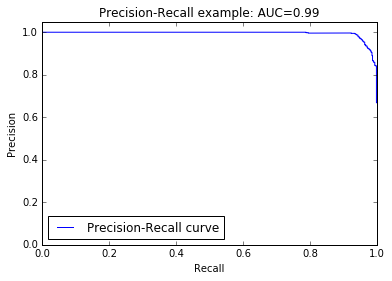

In [30]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [31]:

'''
    This example demonstrates the use of Convolution1D
    for text classification.
    Based on the examples from the Keras website  http://keras.io/
'''

# set parameters:
MAX_FEATURES= num_words
MAX_LEN = 100

batch_size = 128
embedding_dims = 16
nb_filter = 32
filter_length = 3
hidden_dims = 250
nb_epoch = 3

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')

print("Pad sequences (samples x time)")
X_train = sequence.pad_sequences(X_train, maxlen=MAX_LEN)
X_test = sequence.pad_sequences(X_test, maxlen=MAX_LEN)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(MAX_FEATURES, embedding_dims, input_length=MAX_LEN))
model.add(Dropout(0.25))

# we add a Convolution1D, which will learn nb_filter
# word group filters of size filter_length:
model.add(Convolution1D(nb_filter=nb_filter,
                        filter_length=filter_length,
                        border_mode="valid",
                        activation="relu",
                        subsample_length=1))
# we use standard max pooling (halving the output of the previous layer):
model.add(MaxPooling1D(pool_length=2))

# We flatten the output of the conv layer, so that we can add a vanilla dense layer:
model.add(Flatten())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', class_mode="binary", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, show_accuracy=True, validation_data=(X_test, y_test))#, 
          #sample_weight = sw, class_weight = {0:1., 1:25.})
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score: %.3f' %score[0])
print('Test accuracy: %.2f' % score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

(3688, 'train sequences')
(1230, 'test sequences')
Pad sequences (samples x time)
('X_train shape:', (3688L, 100L))
('X_test shape:', (1230L, 100L))
Build model...


C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:336: UserWarning: "class_mode" argument is deprecated, please remove it.
  warnings.warn('"class_mode" argument is deprecated, '
C:\Users\CR107\Anaconda2\lib\site-packages\keras\models.py:396: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


Train on 3688 samples, validate on 1230 samples
Epoch 1/3
3688/3688 [==============================] - 7s - loss: 2.1901 - acc: 0.6592 - val_loss: 0.4065 - val_acc: 0.9528
Epoch 2/3
3688/3688 [==============================] - 7s - loss: 0.5015 - acc: 0.9553 - val_loss: 0.1609 - val_acc: 0.9675
Epoch 3/3
1230/1230 [==============================] - 0s     
Test score: 0.190
Test accuracy: 0.93
*** AUC for ROC = 0.997

1216/1230 [============================>.] - ETA: 0s
Accuracy: 0.927642276423
Recall: 0.988313856427
Precision: 0.878338278932
F1: 0.930086410055
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.99      0.87      0.93       631
   Relevant       0.88      0.99      0.93       599

avg / total       0.93      0.93      0.93      1230

confusion matrix:
[[549  82]
 [  7 592]]


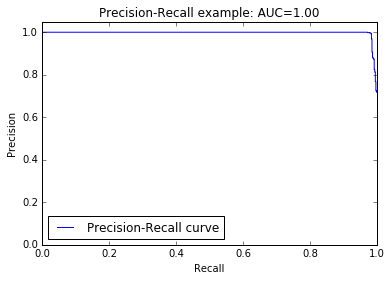

In [32]:
# Plot Precision-Recall curve
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)
average_precision = metrics.average_precision_score(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")
#plt.show()

In [33]:
#### LSTM
model = Sequential()

model.add(Embedding(num_words, 50))
model.add(Dropout(0.25))

model.add(LSTM(32))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.5))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print "fitting model ...."
model.fit(X_train, y_train, batch_size=1, nb_epoch=5, verbose=0,validation_data=(X_test, y_test))#, sample_weight = sw, class_weight = {0:1., 1:25.})

score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

fitting model ....
1230/1230 [==============================] - 0s     
('Test score:', 0.1261181177266654)
('Test accuracy:', 0.97723577235772363)
*** AUC for ROC = 0.992

1216/1230 [============================>.] - ETA: 0s
Accuracy: 0.977235772358
Recall: 0.978297161937
Precision: 0.975041597338
F1: 0.976666666667
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.98      0.98       631
   Relevant       0.98      0.98      0.98       599

avg / total       0.98      0.98      0.98      1230

confusion matrix:
[[616  15]
 [ 13 586]]


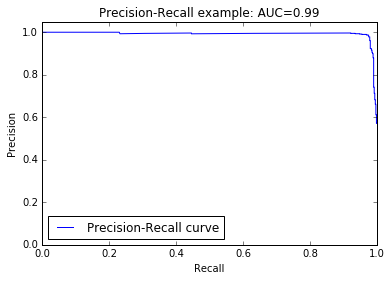

In [34]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [35]:
model = Sequential()

model.add(Embedding(num_words, 32, input_length=100))
model.add(Dropout(0.25))

model.add(GRU(32,activation='relu'))

model.add(Dense(256, W_regularizer=l2(0.01), activity_regularizer=activity_l2(0.01)))
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

print "fitting model ...."
model.fit(X_train, y_train, batch_size=32, nb_epoch=20, verbose=0,validation_data=(X_test, y_test))#, sample_weight = sw,class_weight = {0:1., 1:25.})
score = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=1, show_accuracy=True)
print('Test score:', score[0])
print('Test accuracy:', score[1])

y_score = model.predict(X_test, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y_test, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X_test)
y_test = np.array(y_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y_test, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))

fitting model ....
1230/1230 [==============================] - 0s     
('Test score:', 0.12943654036134239)
('Test accuracy:', 0.97235772183270963)
*** AUC for ROC = 0.991

1216/1230 [============================>.] - ETA: 0s
Accuracy: 0.972357723577
Recall: 0.979966611018
Precision: 0.963875205255
F1: 0.971854304636
classification report:
             precision    recall  f1-score   support

 Irrelevant       0.98      0.97      0.97       631
   Relevant       0.96      0.98      0.97       599

avg / total       0.97      0.97      0.97      1230

confusion matrix:
[[609  22]
 [ 12 587]]


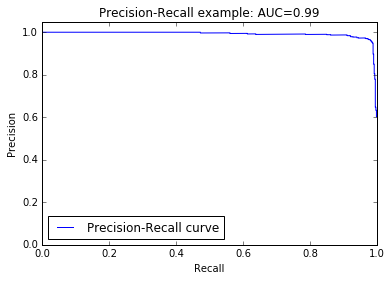

In [36]:
average_precision = metrics.average_precision_score(y_test, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y_test, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")

In [37]:
y_score = model.predict(X, batch_size=batch_size)
auc_score = metrics.roc_auc_score(y, y_score)
print("*** AUC for ROC = %0.3f\n" % auc_score)

y_pred = model.predict_classes(X)
y_test = np.array(y)
accuracy = accuracy_score(y, y_pred)
recall = recall_score(y, y_pred)
precision = precision_score(y, y_pred)
f1 = f1_score(y, y_pred)

print('\nAccuracy: {}'.format(accuracy))
print('Recall: {}'.format(recall))
print('Precision: {}'.format(precision))
print('F1: {}'.format(f1))

print("classification report:")
print(metrics.classification_report(y, y_pred,target_names=categories))

print("confusion matrix:")
print(metrics.confusion_matrix(y, y_pred))

*** AUC for ROC = 0.950

2496/2498 [============================>.] - ETA: 0s
Accuracy: 0.987990392314
Recall: 0.794871794872
Precision: 0.584905660377
F1: 0.673913043478
classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.99      0.99      2459
   Relevant       0.58      0.79      0.67        39

avg / total       0.99      0.99      0.99      2498

confusion matrix:
[[2437   22]
 [   8   31]]


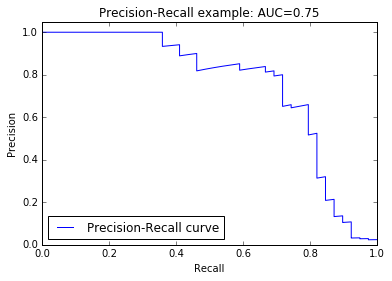

In [38]:
average_precision = metrics.average_precision_score(y, y_score)
precision, recall, threshold = metrics.precision_recall_curve(y, y_score)

plt.clf()
plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision))
plt.legend(loc="lower left")